In [1]:
datasetName = 'eye_eye_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/eye_eye_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalEyes_1.CTGTGTGCCCTCGTAATG,FetalEyes_1.ACGTTGCTGTGTCTGTGT,FetalEyes_1.ACTTATTCACTTAGTTTA,FetalEyes_1.ACGAGCCCAGACAAAGTT,FetalEyes_1.AAGCGGTGCAATCTTCTG
,<int>,<int>,<int>,<int>,<int>
A2M,0,17,7,0,11
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0
A4GALT,0,0,0,0,0
AAAS,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalEyes_1.CTGTGTGCCCTCGTAATG,eye,FetalEyes,FetalEyes,normal,Donor11,female,11 weeks old
FetalEyes_1.ACGTTGCTGTGTCTGTGT,eye,FetalEyes,FetalEyes,normal,Donor11,female,11 weeks old
FetalEyes_1.ACTTATTCACTTAGTTTA,eye,FetalEyes,FetalEyes,normal,Donor11,female,11 weeks old
FetalEyes_1.ACGAGCCCAGACAAAGTT,eye,FetalEyes,FetalEyes,normal,Donor11,female,11 weeks old
FetalEyes_1.AAGCGGTGCAATCTTCTG,eye,FetalEyes,FetalEyes,normal,Donor11,female,11 weeks old


[1] <NA>             <NA>             Endothelial cell <NA>            
[5] <NA>            
23 Levels: Antigen presenting cell (RPS high) Basal cell ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


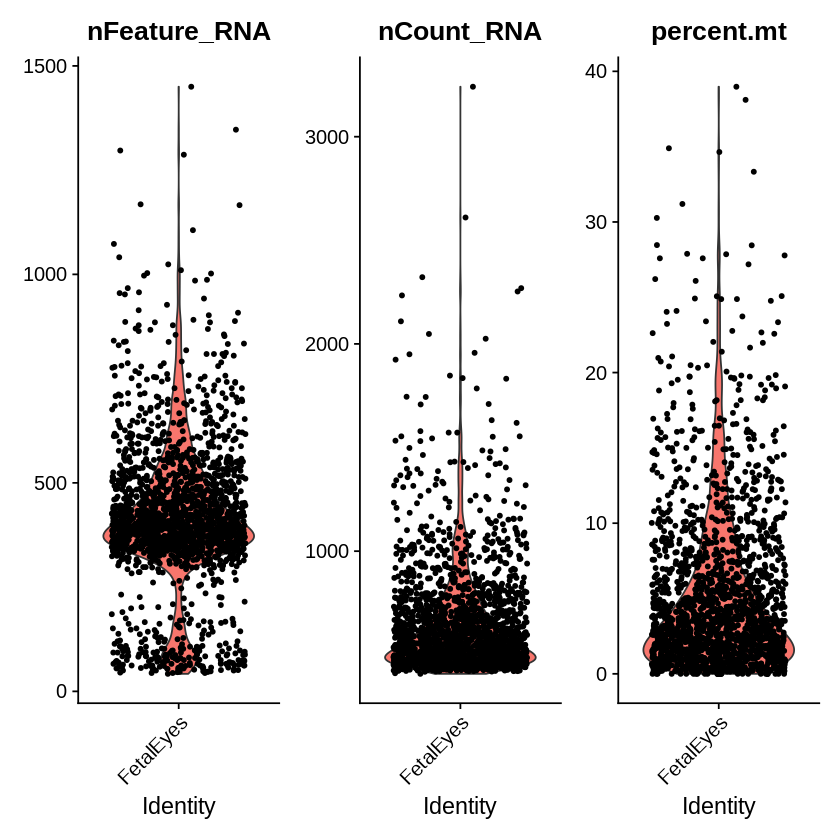

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  STMN2, CRABP1, TUBA1A, GAP43, CALM2, MLLT11, UCHL1, TUBB2B, ELAVL4, NSG1 
	   RTN1, SNCG, TMSB10, ACAT2, TAGLN3, TUBB2A, GNG3, C4orf48, STMN4, HMGCS1 
	   SOX4, BNIP3, PRPH, BEX1, ISL1, SYT4, OLFM1, PGK1, PKM, CD24 
Negative:  ESAM, A2M, CD93, COL4A1, HSPG2, CAV1, ECSCR, IGFBP3, CDH5, RGCC 
	   PECAM1, HLA-B, CLEC14A, CD34, B2M, PRND, ADGRF5, ADGRL4, EGFL7, COL4A2 
	   RNASE1, EMP1, TM4SF1, PTPRB, KLF2, HLA-E, SPARC, VIM, NOTCH4, EFCAB14 
PC_ 2 
Positive:  TUBA1A, TMSB10, GAP43, STMN2, CRABP1, CALM2, UCHL1, ESAM, MLLT11, COL4A1 
	   CD93, A2M, SNCG, ECSCR, CLEC14A, IGFBP3, TMSB4X, PRND, RTN1, ELAVL4 
	   HSPG2, CDH5, NSG1, CLDN5, TUBB2B, ADGRL4, PTPRB, RGCC, PECAM1, NOTCH4 
Negative:  COL1A2, COL1A1, LGALS1, COL3A1, DCN, MGP, SPARC, PLAC9, HES1, OLFML3 
	   S100A11, HMGB2, OGN, IGFBP5, SULT1E1, MDK, LUM, S100A6, COL5A1, PTTG1 
	   HMGN2, CTSC, GSTP1, PCOLCE, PMEL, KIAA0101, SOSTDC1, FOS, ANXA5, MFAP4 
PC_ 3 
Positive:  PMEL, DCT, TFPI2, WNT2B, TYR, SLC38A11, TRPM3, TY

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


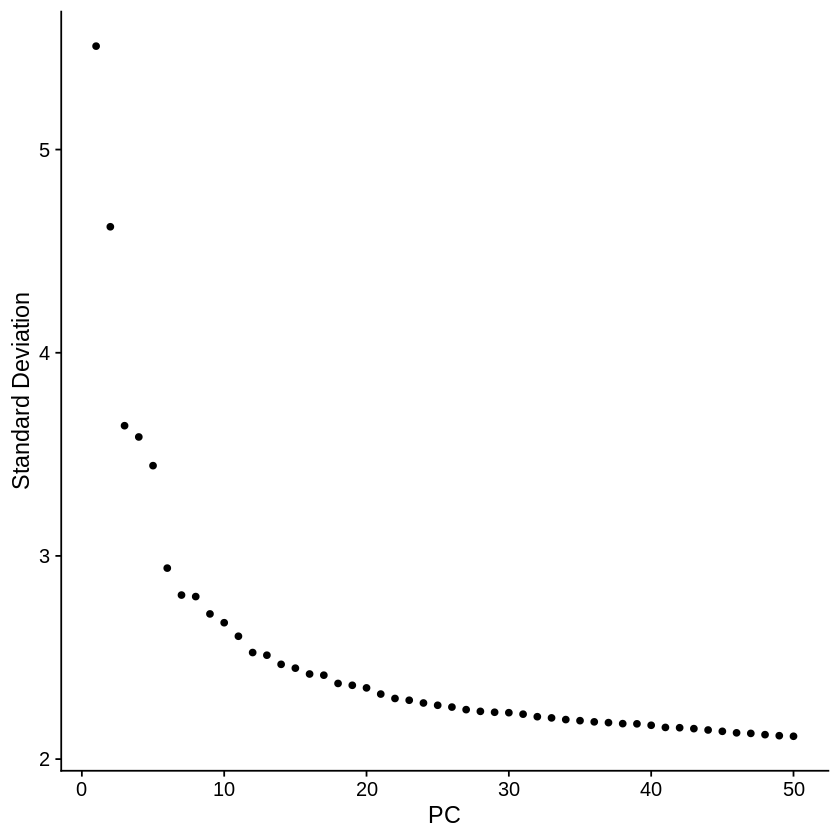

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:12:35 UMAP embedding parameters a = 0.9922 b = 1.112

21:12:35 Read 998 rows and found 10 numeric columns

21:12:35 Using Annoy for neighbor search, n_neighbors = 30

21:12:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:12:35 Writing NN index file to temp file /tmp/Rtmptvy0Kp/file2144ab208b2

21:12:35 Searching Annoy index using 1 thread, search_k = 3000

21:12:36 Annoy recall = 100%

21:12:36 Commencing smooth kNN distance calibration using 1 thread

21:12:36 Initializing from

In [14]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 998
Number of edges: 35325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7701
Number of communities: 9
Elapsed time: 0 seconds


21:13:13 UMAP embedding parameters a = 0.9922 b = 1.112

21:13:13 Read 998 rows and found 10 numeric columns

21:13:13 Using Annoy for neighbor search, n_neighbors = 30

21:13:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:13:13 Writing NN index file to temp file /tmp/Rtmptvy0Kp/file214679bd845

21:13:13 Searching Annoy index using 1 thread, search_k = 3000

21:13:13 Annoy recall = 100%

21:13:13 Commencing smooth kNN distance calibration using 1 thread

21:13:14 Initializing from normalized Laplacian + noise

21:13:14 Commencing optimization for 500 epochs, with 40618 positive edges

21:13:16 Optimization finished



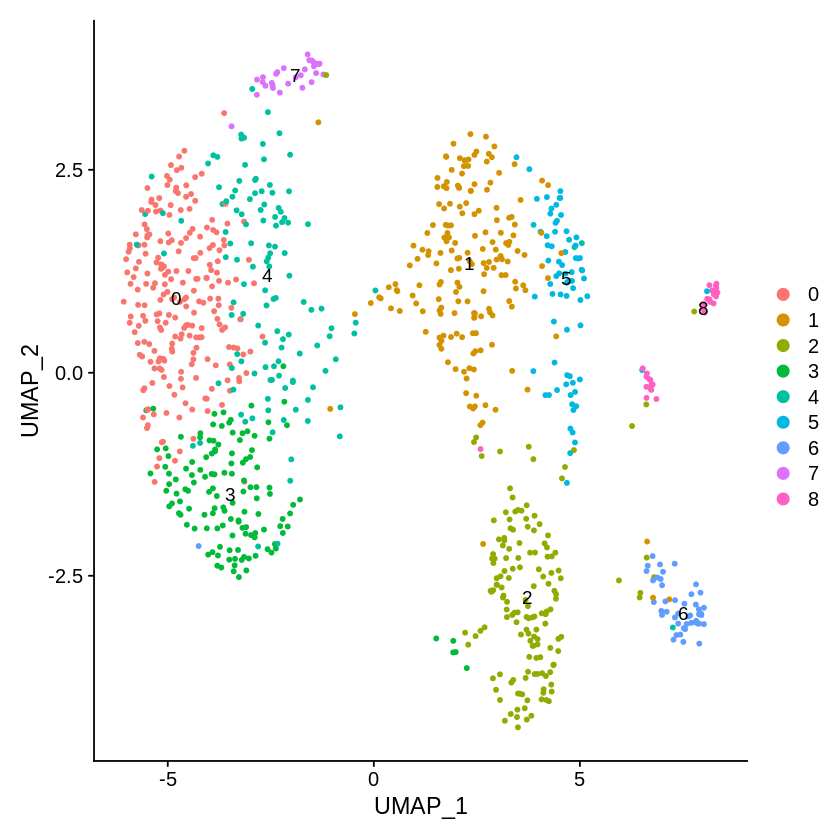

In [15]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [16]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

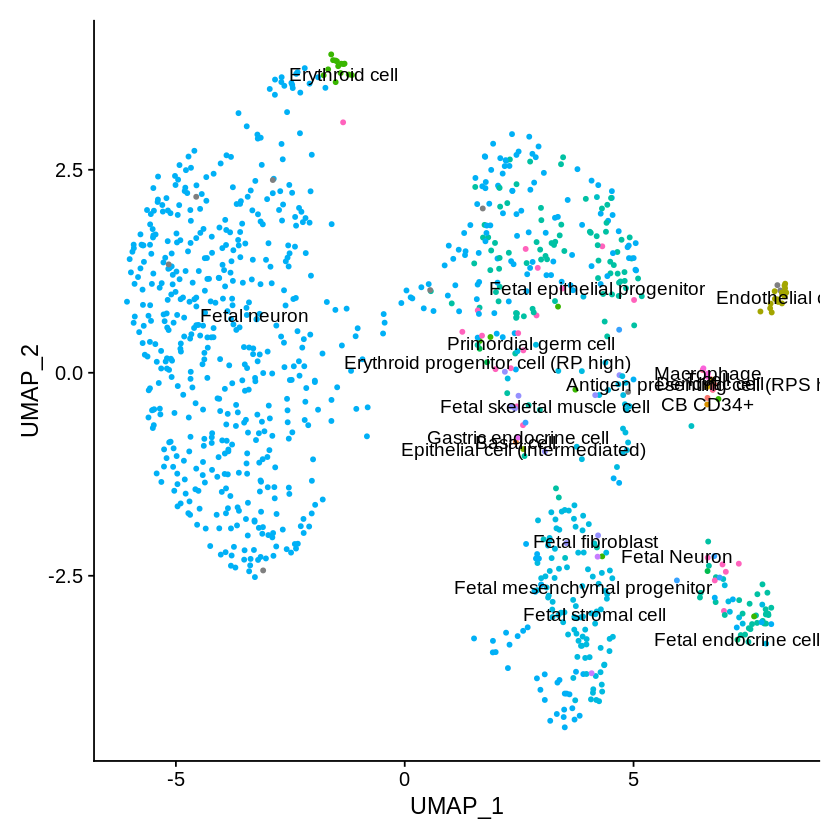

In [20]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [17]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [18]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [21]:
new.cluster.ids <- c('Eye-Nerve tissue-Ganglion cell-GAP43', 'Unknown', 'Eye-Connective tissue-Fibroblast-DCN',
                    'Eye-Nerve tissue-Ganglion cell-GAP43', 'Eye-Nerve tissue-Ganglion cell-GAP43', 'Eye-Connective tissue-Fibroblast-DCN',
                    'Eye-Epithelial tissue-Pigment epithelial cell-DCT', 'Eye-Connective tissue-Erythrocyte-HBA1',  'Eye-Epithelial tissue-Vascular epithelial cell-ESAM')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

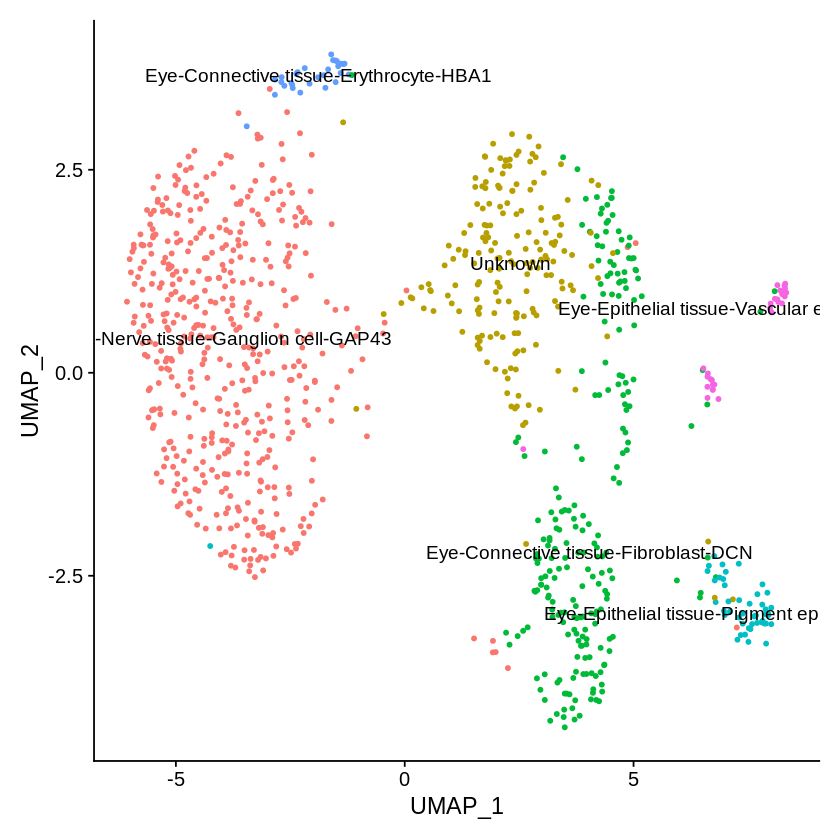

In [22]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [23]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [24]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))